<a href="https://colab.research.google.com/github/alexiamhe93/RedditRepairInitiations/blob/main/S2_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiate notebook



For an easy accessible version of the notebook, click here and go to "S2_File.ipynb":

https://github.com/alexiamhe93/RedditRepairInitiations

This will open up the notebook in Google Colab and can be run directly without the need to sign into any account.

The below cells install R and all relevant packages required for analysis. If checking the BERT model, we advise using a GPU as running on a CPU alone will take a lot of time.

> WARNING: The below cells installing the R packages takes a while to install in Google Colab (aprox. 30 minutes)

In [54]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2
packnames = ('lme4', "AICcmodavg","sjPlot", "MuMIn")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.1-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


(as ‘lib’ is unspecified)






















	‘/tmp/RtmpdjeICt/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7885f0ca5e40> [RTYPES.NILSXP]

In [55]:
%load_ext rpy2.ipython

In [56]:
%%R
install.packages("glmmTMB", type="source")
install.packages("DHARMa", type="source")

(as ‘lib’ is unspecified)







	‘/tmp/RtmpdjeICt/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpdjeICt/downloaded_packages’



Install the [lifelines](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html) package required for the survival analysis. Install the [ktrain](https://github.com/amaiya/ktrain) packagee for running/checking the trained BERT model.

We recommend using a GPU (free T4 on colab will suffice) if running the BERT model.

In [57]:
!pip install lifelines
!pip install ktrain
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

  Using cached https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  Preparing metadata (setup.py) ... done


Load necessary packages for python.

In [58]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
# Plotting
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
from itertools import combinations
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import chisquare
from sklearn.preprocessing import StandardScaler
# For the survival analysis
from lifelines import KaplanMeierFitter,CoxPHFitter,WeibullAFTFitter,AalenAdditiveFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullFitter, ExponentialFitter,LogNormalFitter, LogLogisticFitter
from lifelines import NelsonAalenFitter,PiecewiseExponentialFitter,GeneralizedGammaFitter,SplineFitter
from lifelines.utils import k_fold_cross_validation
from lifelines.plotting import qq_plot
import math

# For validation
import random
from collections import Counter
# For calculating accuracy statistics
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
# For performing basic inferential statistics
import scipy.stats as stats
# For plotting
import plotly.graph_objects as go

In [59]:
from IPython.display import Image

## Download and load data

In [60]:
# for downloading data
import requests, zipfile, io
r = requests.get('https://github.com/alexiamhe93/RedditRepairInitiations/blob/main/data.zip?raw=true' )
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [61]:
## Load data
try:
  # Turn level data
  turn_df0 = pd.read_csv("turn.csv")
  # Dialogue level data
  surv_df0 = pd.read_csv("surv.csv")
  # Full data for descriptives and validation
  desc = pd.read_csv("desc.csv")
except:
  turn_df0 = pd.read_csv("data/turn.csv")
  surv_df0 = pd.read_csv("data/surv.csv")
  desc = pd.read_csv("data/desc.csv")

In [62]:
# This downloads the pretrained BERT model from dropbox - approx. 1/2 minutes depending on download speed
!wget -O initiation_BERT_model_080.zip https://www.dropbox.com/scl/fi/6gl42sqpuwyeujxerg0kz/initiation_BERT_model_080.zip?rlkey=kz5mdjuevmco49gzaiwkdjlb9&st=xtstjq2v&dl=1
!unzip initiation_BERT_model_080.zip

--2024-07-08 15:59:20--  https://www.dropbox.com/scl/fi/6gl42sqpuwyeujxerg0kz/initiation_BERT_model_080.zip?rlkey=kz5mdjuevmco49gzaiwkdjlb9
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc38642277550249fe658a034357.dl.dropboxusercontent.com/cd/0/inline/CWVpn9jtktrRjCG0aBiAWNB4SIyIjEnkC8mUGcOglq5gLdFrhk0hoqHVQOi8CRZBjkAcFovwT6EQCiV5VUz9ZzUfUpnCebgiTh7wqRVi_3P4_WH2BJpC3XsTpN5_T7oKsUAV6LmFaRab1fGrJyjpue92/file# [following]
--2024-07-08 15:59:20--  https://uc38642277550249fe658a034357.dl.dropboxusercontent.com/cd/0/inline/CWVpn9jtktrRjCG0aBiAWNB4SIyIjEnkC8mUGcOglq5gLdFrhk0hoqHVQOi8CRZBjkAcFovwT6EQCiV5VUz9ZzUfUpnCebgiTh7wqRVi_3P4_WH2BJpC3XsTpN5_T7oKsUAV6LmFaRab1fGrJyjpue92/file
Resolving uc38642277550249fe658a034357.dl.dropboxusercontent.com (uc38642277550249fe658a034357.dl.dropboxusercontent.com)... 162

In [63]:
import ktrain
# Load the trained BERT model for identifying initiations
predictor = ktrain.load_predictor('initiation_BERT_model_080')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



In [64]:
# test the predictor on prototypical examples
predictor.predict("I have no idea what you meant by that.")

'initiation'

In [65]:
predictor.predict("The wind kept me up last night.")

'not_initiation'

Get data subsets as these will be useful when it comes to analysis.

In [66]:
# split into manually coded and algorithmic coded data
manual_codes = desc[desc.coded_by == "humans"]
BERT_codes = desc[desc.coded_by == "BERT"]
# split manual coding into train and test data
train_mc = manual_codes[manual_codes.train_test == "train"]
test_mc = manual_codes[manual_codes.train_test == "test"]
# From the manual coding data, fetch all trouble, initiations, and completions
troubles = manual_codes[manual_codes.trouble == 1]
initiations = manual_codes[manual_codes.initiation == 1]
completions = manual_codes[manual_codes.completion == 1]

Process the survival and turn level dataframes for analysis.

In [67]:
turn_df = turn_df0.rename(columns={"subreddit":"sub", "id_threads":"id_thread","author":"id_aut",
                                   "initiation":"CR", "word_count":"wc","PostType":"pType"})

turn_df = turn_df[['sub', 'id_turn', 'id_thread', "id_conv", 'id_aut','turn', 'CR', "wc", "coded_by","pType"]]
surv_df = surv_df0.rename(columns={"subreddit":"sub","id_threads":"id_thread","conversation_id": "id_conv","author":"aut","initiation":"CR","word_count":"wc"})

# Load functions

Functions for conducting descriptive and inferential statistics

In [68]:
def get_descriptive_col(df, col, df_name):
  """
  For basic distribution descriptives
  """
  desc_df = df[col].describe()
  m = desc_df.loc["mean"]
  median = desc_df.loc["50%"]
  std = desc_df.loc["std"]
  min = desc_df.loc["min"]
  max = desc_df.loc["max"]

  print(f"""
  Descriptives for {col} in {df_name}:
  M: {m:.2f}
  SD: {std:.2f}
  Median: {median:.2f}
  Min-max: {min:.2f}-{max:.2f}
  """)

def describe_categorical(df, cat_col, numeric_cols, new_numeric_col_names=None):
  """
  For calculating descriptive statistics per category
  """
  # Rename numerical columns if new_numeric_col_names is provided
  if new_numeric_col_names:
    rename_dict = {old: new for old, new in zip(numeric_cols, new_numeric_col_names)}
    df = df.rename(columns=rename_dict)
    numeric_cols = new_numeric_col_names
  # Group by the categorical column and calculate the count and percentage
  cat_summary = df[cat_col].value_counts().reset_index()
  cat_summary.columns = [cat_col, 'count']
  cat_summary['percentage'] = (cat_summary['count'] / len(df)) * 100
  cat_summary['n (% of data)'] = cat_summary.apply(lambda row: f"{row['count']} ({row['percentage']:.2f}%)", axis=1)
  cat_summary = cat_summary.drop(columns=['count', 'percentage'])
  # For each numeric column, calculate the mean and standard deviation grouped by the categorical column
  for col in numeric_cols:
    stats = df.groupby(cat_col)[col].agg(['mean', 'std']).reset_index()
    stats.columns = [cat_col, f'M {col}', f'SD {col}']
    stats[f'{col}'] = stats.apply(lambda row: f"M={row[f'M {col}']:.2f} (SD={row[f'SD {col}']:.2f})", axis=1)
    stats = stats[[cat_col, f'{col}']]
    cat_summary = cat_summary.merge(stats, on=cat_col, how='left')
  return cat_summary

def calculate_accuracy(true_scores, test_scores):
  """
  For calculating predictive accuracy statistics for assessing classifier performance.
  """
  # Calculate AUC-ROC
  auc_roc = roc_auc_score(true_scores, test_scores)
  print(f'AUC-ROC: {auc_roc:.2f}\n')
  # Compute precision-recall curve
  precision, recall, thresholds = precision_recall_curve(true_scores, test_scores)
  # Calculate AUC-PR
  auc_pr = auc(recall, precision)
  print(f'AUC-PR: {auc_pr:.2f}\n')
  print(classification_report(true_scores,test_scores))
  conf_mx = confusion_matrix(true_scores, test_scores)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx)
  disp.plot()

def KolmogorovSmirnovTest(df1, df2, value_column, category_column, alpha=0.01):
  """
  Tests whether there is a significant difference between the distributions
  of the value_column across turns (category_column) in two dataframes using the KS test.
  Prints a report of the findings.
  """
  values_df1 = df1[[category_column, value_column]].sort_values(by=category_column)[value_column].to_numpy()
  values_df2 = df2[[category_column, value_column]].sort_values(by=category_column)[value_column].to_numpy()
  ks_stat, p_value = stats.ks_2samp(values_df1, values_df2)
  print(f"Kolmogorov-Smirnov Test for {value_column} by {category_column}")
  print(f"Significance level (alpha): {alpha}")
  print(f"KS Statistic: {ks_stat:.2f}")
  print(f"P-value: {p_value:.5f}\n")
  if p_value < alpha:
      print(f"The p-value is below the significance level (sig level = {alpha}).")
      print("There is a significant difference between the distributions.")
  else:
      print(f"The p-value is above the significance level (sig level = {alpha}).")
      print("There is no significant difference between the distributions")

def Chi2(categorical_lst, alpha = 0.01):
  """
  Chi-square test for identifying significant differences between groups.
  """
  # Count the frequency of each category
  observed_freq = Counter(categorical_lst)
  # Get the observed frequencies in the order of categories
  observed_values = list(observed_freq.values())
  # If you have an expected distribution, you can define it. For example, equal distribution:
  expected_values = [len(categorical_lst) / len(observed_freq)] * len(observed_freq)
  # Perform the Chi-Square Goodness of Fit test
  chi2_stat, p_value = stats.chisquare(f_obs=observed_values, f_exp=expected_values)
  print(f"Chi-Square Statistic: {chi2_stat:.2f}")
  print(f"P-Value: {p_value:.5f}")
  # Interpretation
  if p_value < alpha:
      print(f"The frequency of the categories is significantly different (sig level = {alpha}).")
  else:
      print(f"The frequency of the categories is not significantly different (sig level = {alpha}).")

Functions for plotting

In [69]:
def plot_bar_charts_ratio(df1, df2, value_column, category_column,df1_name = "Manual Coding", df2_name = "Algorithmic Coding",
                          return_print = False, fig_name = "plots/barRatio.png"):
    """
    Plots bar charts of the ratio of a variable for each value of another variable in two dataframes side by side.
    """
    # Group by the category column and calculate the ratio of the value_column
    data1 = df1.groupby(category_column)[value_column].sum().reset_index()
    data2 = df2.groupby(category_column)[value_column].sum().reset_index()

    data1['Ratio'] = data1[value_column] / data1[value_column].sum()
    data2['Ratio'] = data2[value_column] / data2[value_column].sum()

    # Create a combined dataframe for plotting
    combined_data = pd.concat([
        data1.assign(DataFrame=df1_name),
        data2.assign(DataFrame=df2_name)
    ])

    # Plot the bar chart using Plotly
    fig = go.Figure()

    for df_name, df_group in combined_data.groupby('DataFrame'):
        fig.add_trace(go.Bar(
            x=df_group[category_column],
            y=df_group['Ratio'],
            name=df_name,
            text=df_group['Ratio'].apply(lambda x: f'{x:.2%}'),
            textposition='auto'
        ))

    # Customize layout
    fig.update_layout(
        title=f'{value_column} ratios for each {category_column}',
        xaxis_title=category_column,
        yaxis_title='Ratio',
        barmode='group',
        yaxis_tickformat=',.0%',
        xaxis_tickangle=-45
    )
    if return_print:
      # Specify the path to save the image
      image_path = f"{fig_name}.png"
      # Ensure the directory exists
      os.makedirs(os.path.dirname(image_path), exist_ok=True)
      # Save the plot as a static image
      fig.write_image(image_path)
      # Show the plot
    else:
      fig.show()

def create_subplot_grid(data, columns, target_column, switch_axes=False):
    """
    Create a gridded subplot for a DataFrame with specified target column and multiple feature columns.
    """
    num_subplots = len(columns)
    fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

    for i, column in enumerate(columns):
        x_values = data[column] if not switch_axes else data[target_column]
        y_values = data[target_column] if not switch_axes else data[column]

        ax = axes[i] if num_subplots > 1 else axes
        ax.scatter(x_values, y_values, label=f'{column} vs {target_column}')
        ax.set_xlabel(column if not switch_axes else target_column)
        ax.set_ylabel(target_column if not switch_axes else column)
        ax.legend()

    plt.tight_layout()
    plt.show()

def create_histogram_subplot_grid(data, columns, bins=10):
    """
    Create a gridded subplot with histograms for specified columns in a DataFrame.
    """
    num_subplots = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(15, 5))

    for i, column in enumerate(columns):
        ax = axes[i] if num_subplots > 1 else axes
        ax.hist(data[column], bins=bins, edgecolor='black')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def create_grouped_histograms_plotly(data, x, group):
    """
    Create grouped histograms using Plotly for a DataFrame with a specified variable and grouping column.
    """
    fig = px.histogram(data, x=x, color=group, marginal="rug", facet_col=group)
    fig.show()

def plot_dataframe(df):
    """
    For plotting subreddits
    """
    melted_df = df.melt(id_vars='sub', var_name='category', value_name='value')
    fig = px.bar(melted_df, x='sub', y='value', color='category',
                 labels={'value': 'Value', 'sub': 'Sub', 'category': 'Category'},barmode="group")
    fig.update_layout(height=500, width=800)
    fig.show()


def plot_turnCR(df, nrows=2):
    # Create subplots
    fig = make_subplots(rows=nrows, cols=1, shared_xaxes=True, vertical_spacing=0.1)

    # Set color palette
    colors = px.colors.qualitative.Set1

    # Calculate total counts for ratio calculation
    total_counts = df['Dialogue count'].sum()
    total_log_counts = df['Log(Dialogue count)'].sum()

    # Add traces for the first plot
    for i, (initiation_type, group_df) in enumerate(df.groupby('initiation')):
        fig.add_trace(
            go.Bar(
                x=group_df['Dialogue Length'],
                y=group_df['Dialogue count'],
                name=initiation_type,
                marker_color=colors[i % len(colors)],
                text=group_df['Dialogue count'] / total_counts,
                texttemplate='%{text:.2%}',
                textposition='auto'
            ),
            row=1, col=1
        )

    # Add traces for the second plot
    for i, (initiation_type, group_df) in enumerate(df.groupby('initiation')):
        fig.add_trace(
            go.Bar(
                x=group_df['Dialogue Length'],
                y=group_df['Log(Dialogue count)'],
                showlegend=False,
                marker_color=colors[i % len(colors)],
                text=group_df['Log(Dialogue count)'] / total_log_counts,
                texttemplate='%{text:.2%}',
                textposition='auto'
            ),
            row=2, col=1
        )

    # Update layout
    fig.update_layout(
        barmode='group',
        xaxis_title='Dialogue Length',
        title_text='',
        width=1000,
        height=600,
        legend_title_text='Contains repair initiation',
    )

    # Update x-axes
    fig.update_xaxes(tickmode='array', tickvals=df['Dialogue Length'].unique(), row=1, col=1)
    fig.update_xaxes(tickmode='array', tickvals=df['Dialogue Length'].unique(), row=2, col=1)
    if nrows == 3:
        fig.update_xaxes(tickmode='array', tickvals=df['Dialogue Length'].unique(), row=3, col=1)

    # Update y-axes
    fig.update_yaxes(title_text='Dialogue count', row=1, col=1)
    fig.update_yaxes(title_text='Log dialogue count', row=2, col=1)
    if nrows == 3:
        fig.update_yaxes(title_text='Log Centered dialogue count', row=3, col=1)
        fig.update_xaxes(title_text='Dialogue Length (turns)', row=3, col=1)

    fig.show()




def plotInitiations_subreddits(surv_df, turn_df, value_col='CR', group_col='sub'):
    # Data for subplot 1
    sub_df1 = surv_df.groupby(group_col)[value_col].agg("mean").reset_index()
    sub_df1.columns = ["Subreddit", "initiation"]
    sub_df1["No initiation"] = 1 - sub_df1["initiation"]
    sub_df1 = sub_df1.sort_values("initiation")

    # Data for subplot 2
    sub_df2 = turn_df.groupby(group_col)[value_col].agg("mean").reset_index()
    sub_df2.columns = ["Subreddit", "initiation"]
    sub_df2["No initiation"] = 1 - sub_df2["initiation"]
    sub_df2 = sub_df2.sort_values("initiation")

    # Create subplots
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

    # Define colors
    initiation_color = 'red'
    no_initiation_color = 'blue'

    # Add traces for subplot 1
    fig.add_trace(
        go.Bar(
            x=sub_df1["initiation"],
            y=sub_df1["Subreddit"],
            name="initiation",
            orientation='h',
            text=sub_df1["initiation"].apply(lambda x: f'{x:.2%}'),
            textposition='auto',
            marker_color=initiation_color
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=sub_df1["No initiation"],
            y=sub_df1["Subreddit"],
            name="No initiation",
            orientation='h',
            marker_color=no_initiation_color
        ),
        row=1, col=1
    )

    # Add traces for subplot 2 with specified colors
    fig.add_trace(
        go.Bar(
            x=sub_df2["initiation"],
            y=sub_df2["Subreddit"],
            name="initiation",
            orientation='h',
            text=sub_df2["initiation"].apply(lambda x: f'{x:.2%}'),
            textposition='auto',
            marker_color=initiation_color
        ),
        row=1, col=2
    )

    fig.add_trace(
        go.Bar(
            x=sub_df2["No initiation"],
            y=sub_df2["Subreddit"],
            name="No initiation",
            orientation='h',
            marker_color=no_initiation_color
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(height=800, width=1000, showlegend=True, barmode='relative')

    # For subplot 1, remove the legend
    fig.update_traces(showlegend=False, row=1, col=1)

    # Update x-axis titles
    fig.update_xaxes(title_text='Proportion of dialogues with initiation', row=1, col=1)
    fig.update_xaxes(title_text='Proportion of turns with initiation', row=1, col=2)

    # Update y-axis to hide ticks for subplot 2
    fig.update_yaxes(showticklabels=True, row=1, col=1)
    fig.update_yaxes(showticklabels=False, row=1, col=2)

    # Show plot
    fig.show()

def plot_histogram_overlay(dataframes, column_name, labels=None, opacity=0.5):
    """
    Plots histograms of a specified column for multiple dataframes on top of each other with given opacity.
    """
    fig = go.Figure()

    # If no labels provided, use default labels
    if labels is None:
        labels = [f'DataFrame {i+1}' for i in range(len(dataframes))]

    for df, label in zip(dataframes, labels):
        fig.add_trace(
            go.Histogram(
                x=df[column_name],
                opacity=opacity,
                name=label
            )
        )

    # Update layout
    fig.update_layout(
        barmode='overlay',
        title=f'Overlayed Histograms of {column_name}',
        xaxis_title=column_name,
        yaxis_title='Count',
        width=800,
        height=600,
        legend_title_text='DataFrames'
    )

    # Show plot
    fig.show()

def plot_simpleBar(df, category_column):
    """
    Plots a bar chart of the frequency count ratio for each value of a specified column in the dataframe.

    """
    # Calculate the frequency count and ratio
    frequency_data = df[category_column].value_counts().reset_index()
    frequency_data.columns = [category_column, 'Count']
    frequency_data['Ratio'] = frequency_data['Count'] / frequency_data['Count'].sum()

    # Plot the bar chart using Plotly
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=frequency_data[category_column],
        y=frequency_data['Ratio'],
        text=frequency_data['Ratio'].apply(lambda x: f'{x:.2%}'),
        textposition='auto',
        name='Ratio'
    ))

    # Customize layout
    fig.update_layout(
        title=f'Frequency count ratios for each {category_column}',
        xaxis_title=category_column,
        yaxis_title='Ratio',
        barmode='group',
        yaxis_tickformat=',.0%',
    )

    # Show the plot
    fig.show()

Functions for survival analysis

In [70]:

def fit_and_score_features2(X, event_col="status",time_ = "time"):
  """
  Get the feature scores for model selection:
  Adapted from: https://stackoverflow.com/questions/53467348/feature-covariates-selection-in-coxphfitter-lifelines-survival-analysis
  """
  y=X[[time_,status]]
  X.drop([time_, status], axis=1, inplace=True)
  n_features = X.shape[1]
  scores = np.empty(n_features)
  m = CoxPHFitter()
  for j in range(n_features):
      Xj = X.iloc[:, j:j+1]
      Xj=pd.merge(Xj, y,  how='right', left_index=True, right_index=True)
      m.fit(Xj, duration_col=time_, event_col=event_col, show_progress=True)
      scores[j] = m.score(Xj) #,scoring_method='concordance_index') # Currently calculating loglikelihood
  return scores

# For Lifelines model fit.

def partial_AIC_(df,model_names, models):
  """
  Fetches the Partial AIC for comparing model performance.
  """
  assumptions = []
  AIC_list = []
  for i in range(0,len(models)):
    try:
      AIC_list.append(models[i].AIC_partial_)
    except:
      AIC_list.append(0)
  AIC_df =pd.DataFrame({"Model":model_names, "Partial AIC":AIC_list})
  AIC_df = AIC_df.sort_values("Partial AIC").round(3)
  return AIC_df

def AIC_BIC(df,model_names, models):
  """
  Fetches the AIC and BIC for comparing model performance.
  """
  assumptions = []
  AIC_list = []
  BIC_list = []
  for i in range(0,len(models)):
    try:
      AIC_list.append(models[i].AIC_)
      BIC_list.append(models[i].BIC_)
    except:
      AIC_list.append(0)
      BIC_list.append(9)
  AIC_df =pd.DataFrame({"Model":model_names, "AIC":AIC_list, "BIC":BIC_list})
  AIC_df = AIC_df.sort_values("AIC").round(3)
  return AIC_df


def convertHazard_to_density(cum_hazard, return_survival=False):
  """
  Calculates the cumulative density from the cumulative hazard (e^(-Hazard))
  """
  survival = math.exp(-cum_hazard)
  if return_survival:
    return survival
  else:
    return 1 - survival

def get_cumulative_density(model, max_time = 36, return_survival=False):
  """
  Iterate over time points and calculate cumulative density
  """
  times = list(range(1,max_time))
  dens_lst = []
  for t in times:
    cum_hazard = model.cumulative_hazard_at_times(t)
    dens_ = convertHazard_to_density(cum_hazard, return_survival)
    dens_lst.append(dens_)
  return pd.DataFrame({"Time":times,"Cumulative density":dens_lst})

def plot_exponential_density(T, E, max_time=12):
    """
    Fits and plots the Exponential and Kaplan-Meier cumulative density functions.
    """
    # Initialize Exponential fitter
    exp = ExponentialFitter()
    exp.fit(T, event_observed=E, label="Exponential")

    # Get cumulative density
    prd = get_cumulative_density(exp, max_time=max_time)

    # New row to be added
    new_row = {'Time': 0, 'Cumulative density': 0}
    # Concatenate the new row to make it the first row
    prd2 = pd.concat([pd.DataFrame([new_row]), prd]).reset_index(drop=True)

    # Fit and plot Exponential
    exp.cumulative_density_.plot()
    lower_bound = exp.confidence_interval_cumulative_density_['Exponential_lower_0.95']
    upper_bound = exp.confidence_interval_cumulative_density_['Exponential_upper_0.95']
    # Fill between the confidence intervals
    plt.fill_between(exp.cumulative_density_.index, lower_bound, upper_bound, alpha=0.3, color='blue')
    # Add a dashed line at y > 0.5 and the x value closest to an integer
    threshold = 0.5
    plt.axvline(x=round(exp.median_survival_time_, 0), linestyle='--', color='blue', label=f'Exponential median', ymax=threshold, linewidth=1, alpha=0.5)

    # Fit and plot Kaplan-Meier
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E, label="Kaplan-Meier")
    kmf.plot_cumulative_density(color="grey", alpha=0.6)
    plt.axvline(x=kmf.median_survival_time_, linestyle='--', color='grey', label=f'Kaplan-Meier median', ymax=threshold, linewidth=1, alpha=0.7)

    # Plot PRD with an extra point at (0, 0)
    plt.plot(prd2['Time'], prd2['Cumulative density'], linestyle='--', color='blue', label='', linewidth=0.5)

    # Rest of the code remains unchanged
    old_ticks = list(range(0, max_time-1))
    new_ticks = list(range(1, max_time))
    plt.xticks(old_ticks, new_ticks)
    # Set custom ticks on the y-axis at 0.1 intervals
    custom_ticks_y = np.arange(0, 1.1, 0.1)
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)
    plt.yticks(custom_ticks_y)
    plt.xlabel('Turn')
    plt.ylabel('Cumulative density')
    plt.grid(True, alpha=0.5)
    plt.show()

# Validating BERT classifier


This section reports on validity checks of the BERT classifier, checking to see if it appropriately reproduces the manual coding.

In [71]:
manual_codes.head()

,subreddit,id_turn,id_conv,id_threads,turn,TimeToInitiation,author,BERT_scores,trouble,initiation,completion,completed_by,clarification_type,train_test,coded_by,word_count,PostType
15522,IAmA,turn_7553,conv_4497,thread_4497,1,2.0,A,0.0,1,0,0,NaN,_none_,Not_applicable,humans,80,Text
15523,IAmA,turn_18075,conv_4497,thread_4497,2,2.0,B,1.0,0,1,0,Self,restricted request,train,humans,8,Text
15524,IAmA,turn_18076,conv_4497,thread_4497,3,2.0,A,0.0,1,0,1,NaN,_none_,test,humans,32,Text
15525,IAmA,turn_18077,conv_4497,thread_4497,4,2.0,C,1.0,0,1,0,No_completion,restricted request,train,humans,5,Text
15526,IAmA,turn_18078,conv_4497,thread_4497,5,2.0,D,0.0,0,0,0,NaN,_none_,train,humans,12,Text


In [72]:
n_MC = len(manual_codes)
n_dia_MC = len(manual_codes.id_threads.unique())
n_BERT = len(BERT_codes)
n_dia_BERT = len(BERT_codes.id_threads.unique())
pct_dia_MC = 100*(n_dia_MC/len(surv_df))
pct_turn_MC = 100*(n_MC/len(turn_df))
print(f"""
There are {n_dia_MC + n_dia_BERT} dialogues in the dataset, of which {n_dia_MC} ({pct_dia_MC:.2f}%) were manually coded.
There are {n_MC + n_BERT} turns in the dataset, of which {n_MC} ({pct_turn_MC:.2f}%) were manually coded.
""")


There are 4945 dialogues in the dataset, of which 448 (9.36%) were manually coded.
There are 19852 turns in the dataset, of which 1775 (9.37%) were manually coded.



Calculate accuracy of the BERT scores on the validation data. We remove the first turns as these were excluded from the coding. The reason for exclusion is that the first turn cannot be (by definition) an Other initiation, which comes after a trouble source.

AUC-ROC: 0.88

AUC-PR: 0.82

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       332
           1       0.79      0.81      0.80        62

    accuracy                           0.94       394
   macro avg       0.88      0.88      0.88       394
weighted avg       0.94      0.94      0.94       394



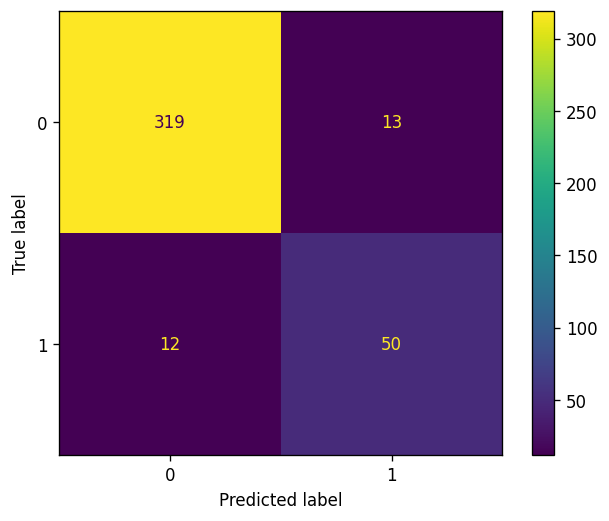

In [73]:
true_scores = test_mc[test_mc.turn!=1].initiation.to_list()
test_scores = test_mc[test_mc.turn!=1].BERT_scores.to_list()
calculate_accuracy(true_scores, test_scores)

The AUC_PR is moderately high (0.82) indicating the classifier is performing well. We can see it only makes 25 errors in classification, with a slightly lower precision than recall.

## Comparing distributions of BERT and human scores

The below graph shows the proportion of turns that are clarification requests, comparing the manually coded data with the BERT coding.

In [74]:
plot_bar_charts_ratio(manual_codes, BERT_codes, "initiation","turn")

In [75]:
#Image('plots/BERT_barplot.png')

We can see that the codes are visually similar, however this does not mean they are sampled from the same underlying distribution (i.e., the algorithm has reproduced the manual coding). We therefore perform a Kolmogorov-Smirnov test to assess the difference between them (equivalent to a t test but non parametric and, subsequently, has fewer assumption):

H0: The two distributions are different.

H1: The two distributions are the same.

In [76]:
KolmogorovSmirnovTest(manual_codes, BERT_codes, "initiation","turn")

Kolmogorov-Smirnov Test for initiation by turn
Significance level (alpha): 0.01
KS Statistic: 0.02
P-value: 0.81283

The p-value is above the significance level (sig level = 0.01).
There is no significant difference between the distributions


We reject the null hypothesis that both distributions are the same. We take this as additional evidence that the classifier accurately reproduces the manual coding.

## Examining BERT misclassifications

In [77]:
# These are false positives extracted from the BERT results
FP = ["What about things that don't have husks? Like nuts or seeds that don't digest?",
      "For kids? Uhh...",
      "Any chance you could open source the art you used here? I'm interested in putting one up in Lake Yvette, Or but too lame to come up with the graphic haha"]

In [78]:
# False negatives
FN = ["you have to slow down in order to go towards the sun... this is so strange to me but i trust you and it kinda makes sense. its like if you are in a car and you want to stop at the curb, you have to slow down to actually reach the curb otherwise you just go past it?",
      "I think you missed the previous part of that sentence, though I don't know what he meant by that either.",
      "Then they need to fix the distribution, not the customer base. I can get you that there are tons of essential workers or other sick people who won't be able to get the vaccine right now but healthy people can because they're taking their parents or grandparents. If they weren't willing to take them before, that's bad. If the elderly weren't willing to go before, then why's that? There's no reason why Mass can't be giving the vaccine to more people in need if every other state is able to do it."]

We can have an in depth look at what the BERT algorithm is doing with the LIME algorithm from the eli5 ([Korobov, 2017](https://av.tib.eu/media/33771);[Korobov & Lopuhin, 2024](https://github.com/eli5-org/eli5)) package and our model:


In [79]:
# false positive examples
predictor.explain(FP[0])

In [80]:
predictor.explain(FP[1])

In [81]:
predictor.explain(FP[2])

We can seee that the main indicators for the false positives are the formulations as questions as would be expected. In the first and second example (`FP[0]` and `FP[1]`), it would be difficult for a person to identify whether these are clarification questions without the added context.

For the third one, thee algorithm is focussing on "chance you" and "art you used" to assign th label. In other questions, this would indicate clarifiation, but for this case, it is not addressing any misunderstanding.

In [82]:
# false negative examples
predictor.explain(FN[0])

In [83]:
predictor.explain(FN[1])

In [84]:
predictor.explain(FN[2])

For the first example `FN[0]`, the algorithm seems to have gotten confused by the word "sense". This is understandable as it would indicate understanding. However, the remaning words are enough to determine a clarification.

The second example `FN[1]` is addressing a previous turn as "he" rather than "you" - this follows on from a second turn where a clarificaton request was initiated. It shars the same trouble source as this initiation and is a clear edge case.

The thd example `FN[2]` is an example of where the completion determined that the request was for a clarification. Initially posed as a rhetorical question, the Self responded as if it *were* a clarification. Most of these questions would not be considered a request.

# Descriptive statistics

## Turn level descriptives

In [85]:
print(f"There are {len(turn_df)} turns in the dataset, sampled from {len(surv_df)} threads.")

There are 18937 turns in the dataset, sampled from 4786 threads.


In [86]:
dia_len_desc = surv_df.dia_len.describe()
dL_m = dia_len_desc.loc["mean"]
dL_median = dia_len_desc.loc["50%"]
dL_std = dia_len_desc.loc["std"]
dL_max = dia_len_desc.loc["max"]
print(f"On average, conversations are {dL_median} turns in length. The distribution of dialogue length is highly skewed (M={dL_m:.2f}; SD={dL_std:.2f}; Min = 1; Max = {dL_max})")

On average, conversations are 3.0 turns in length. The distribution of dialogue length is highly skewed (M=4.03; SD=1.55; Min = 1; Max = 11.0)


We can plot the initiations across the dataset as well. This helps us visualize how the distribution of repair initiations varies for different dialogue lengths. The longer the dialogue, the higher ratio of repairs. This is made more visible after logging the dialogue count.

In [87]:
surv_initiation = surv_df[surv_df.CR != 0]
surv_NOinitiation = surv_df[surv_df.CR == 0]
s_i =  surv_initiation.groupby('dia_len')['CR'].agg(['sum']).reset_index()
s_Ni =  surv_NOinitiation.groupby('dia_len')['CR'].agg(['count']).reset_index()
s_i = s_i.rename(columns = {"sum": "count"})
s_i["initiation"] = "Yes"
s_Ni["initiation"] = "No"
s_all = pd.concat([s_i, s_Ni])
s_all = s_all.rename(columns = {"dia_len":"Dialogue Length","count":"Dialogue count"})
s_all["Log(Dialogue count)"] = np.log(s_all["Dialogue count"])

In [88]:
plot_turnCR(s_all)

In [89]:
#Image('plots/initiation_barplot.png')

To further illustrate the skewed distribution:

In [90]:
total_dialogues = s_all["Dialogue count"].sum()
FewerThan_3_turns = s_all[s_all["Dialogue Length"] < 4]["Dialogue count"].sum()
ratio =  FewerThan_3_turns /total_dialogues * 100
print(f"""
Of {total_dialogues} dialogues, {FewerThan_3_turns} ({ratio:.2f}%) are <= 3 turns long.
""")


Of 4786 dialogues, 2503 (52.30%) are <= 3 turns long.



In [91]:
total_dia_wRepair = surv_df.CR.sum()
pct_dialogue_repair = round((total_dia_wRepair/len(surv_df))*100,2)
print(f"There are {total_dia_wRepair} repair initiations ({pct_dialogue_repair}%) in the dataset")

There are 1966 repair initiations (41.08%) in the dataset


## Subreddit level descriptives

Shows the word counts and clarification requests across the data.

In [92]:
turn_summary = describe_categorical(desc, 'subreddit', ["word_count", "initiation"],["wc","CR"])
turn_summary.round(2)

,subreddit,n (% of data),wc,CR
0,changemyview,1861 (9.37%),M=151.20 (SD=183.58),M=0.16 (SD=0.36)
1,politics,1359 (6.85%),M=31.31 (SD=52.97),M=0.12 (SD=0.33)
2,askreddit,1290 (6.50%),M=20.67 (SD=52.84),M=0.11 (SD=0.32)
3,unpopularopinion,1244 (6.27%),M=56.46 (SD=74.80),M=0.13 (SD=0.34)
4,wallstreetbets,1217 (6.13%),M=33.08 (SD=98.94),M=0.13 (SD=0.33)
5,brexit,1018 (5.13%),M=46.24 (SD=74.54),M=0.12 (SD=0.32)
6,publicfreakout,929 (4.68%),M=23.50 (SD=51.84),M=0.12 (SD=0.33)
7,todayilearned,897 (4.52%),M=29.96 (SD=35.03),M=0.11 (SD=0.31)
8,IAmA,887 (4.47%),M=95.61 (SD=128.34),M=0.29 (SD=0.45)
9,coronavirus,783 (3.94%),M=33.36 (SD=50.74),M=0.13 (SD=0.33)


Same but at the dialogue level

In [93]:
dia_summary = describe_categorical(surv_df, 'sub', ["word_count", "initiation"],["wc","CR"])
dia_summary.round(2)

,sub,n (% of data),wc,CR
0,changemyview,360 (7.52%),M=149.96 (SD=98.80),M=0.49 (SD=0.50)
1,askreddit,331 (6.92%),M=19.92 (SD=27.08),M=0.36 (SD=0.48)
2,politics,324 (6.77%),M=29.66 (SD=24.83),M=0.38 (SD=0.49)
3,wallstreetbets,320 (6.69%),M=31.88 (SD=50.68),M=0.40 (SD=0.49)
4,unpopularopinion,294 (6.14%),M=57.19 (SD=40.30),M=0.41 (SD=0.49)
5,todayilearned,225 (4.70%),M=27.96 (SD=19.03),M=0.37 (SD=0.48)
6,publicfreakout,225 (4.70%),M=19.50 (SD=22.27),M=0.37 (SD=0.48)
7,brexit,223 (4.66%),M=41.10 (SD=38.63),M=0.41 (SD=0.49)
8,IAmA,206 (4.30%),M=96.97 (SD=61.27),M=0.90 (SD=0.30)
9,showerthoughts,195 (4.07%),M=17.48 (SD=10.66),M=0.34 (SD=0.47)


We can also plot the number of repair initiations at both levels of analysis.

In [94]:
plotInitiations_subreddits(surv_df, turn_df)

In [95]:
#Image('plots/initiation_subs.png')

We can see from this graph that all of the subreddits contain some repair initiations, varying in frequency. Ask Me Anything (IAmA) has got the highest proportion by a substantial margin.

## Repair level data

We can examine the word counts of trouble, initiations, and completions (manual coded data only). We observe the trouble sources are, on average, a little longer than initiations and completions.

In [96]:
get_descriptive_col(troubles, "word_count", "trouble sources")


  Descriptives for word_count in trouble sources:
  M: 67.90
  SD: 91.25
  Median: 29.00
  Min-max: 1.00-598.00
  


In [97]:
get_descriptive_col(initiations, "word_count", "initiations")


  Descriptives for word_count in initiations:
  M: 44.86
  SD: 75.16
  Median: 19.50
  Min-max: 1.00-610.00
  


In [98]:
get_descriptive_col(completions, "word_count", "completions")


  Descriptives for word_count in completions:
  M: 52.16
  SD: 68.60
  Median: 28.00
  Min-max: 1.00-417.00
  


In [99]:
plot_histogram_overlay([troubles,initiations,completions], "word_count", labels = ["trouble","initiation","completion"])

In [100]:
#Image('plots/wordcount_hist.png')

# Completions statistics

## Preference for self repair

In [101]:
comp_summary = describe_categorical(initiations, 'completed_by', ["word_count"],["wc of initiation"])
comp_summary.round(2)

,completed_by,n (% of data),wc of initiation
0,Self,103 (49.05%),M=44.20 (SD=61.10)
1,Other,55 (26.19%),M=44.80 (SD=90.67)
2,No_completion,52 (24.76%),M=46.21 (SD=83.52)


We can see that the Self does indeed complete at a higher rate than the Other. We can use a Chi2 to see if this difference is statistically significant.

In [102]:
Chi2(initiations.completed_by.to_list())

Chi-Square Statistic: 23.40
P-Value: 0.00001
The frequency of the categories is significantly different (sig level = 0.01).


This supports the view that repairs are completed at a higher rate by the Self than Other online.

We used an algorithm to code the BERT score completions (if Self replies: Self-completed, if Other replies: Other-completed, if no reply: no completion). These values are less accurate as people occasionally reply to a CR without completion, or a completion comes further down.

In [103]:
initiations_2 = BERT_codes[BERT_codes.initiation == 1]
comp_summary = describe_categorical(initiations_2, 'completed_by', ["word_count"],["wc of initiation"])
comp_summary.round(2)

,completed_by,n (% of data),wc of initiation
0,Self,1029 (42.47%),M=35.01 (SD=68.71)
1,Other,945 (39.00%),M=29.61 (SD=52.35)
2,No_Completion,449 (18.53%),M=29.67 (SD=50.15)


In [104]:
Chi2(initiations_2.completed_by.to_list())

Chi-Square Statistic: 243.28
P-Value: 0.00000
The frequency of the categories is significantly different (sig level = 0.01).


Again, this supports a preference for Self completion, even online.

## Preference for specificity

The below examines whether more specific clarification types are preferred. We can see that restricted offers (most specific) are the most common and open requests (least specific) occur incredibly infrequently.

In [105]:
initiations = initiations[initiations["clarification_type"]!= "_none_"]
plot_simpleBar(initiations, "clarification_type")

In [106]:
#Image('plots/initiationType_barplot.png')

Again, we can test the difference between these using a Chi-square test.

In [107]:
Chi2(initiations.clarification_type.to_list())

Chi-Square Statistic: 101.60
P-Value: 0.00000
The frequency of the categories is significantly different (sig level = 0.01).


This supports the idea that people prefer specific requests to non-specific ones.

## Relationship between specificity and completions

This addresses whether there is an association between request types and who has completed the request.

In [108]:

def Chi2_contingencytable(df, var1, var2, test_type='chi2'):
    """
    Analyzes the relationship between two categorical variables.
    """
    # Create the contingency table
    contingency_table = pd.crosstab(df[var1], df[var2])
    # Perform the Chi-square or Fisher's exact test
    if test_type == 'chi2':
        chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
        result = {
            'test': 'Chi-square',
            'chi2': chi2,
            'p-value': p,
            'degrees of freedom': dof
        }
    elif test_type == 'fisher':
        if contingency_table.shape != (2, 2):
            raise ValueError("Fisher's exact test is only applicable for 2x2 contingency tables.")
        oddsratio, p = stats.fisher_exact(contingency_table)
        result = {
            'test': 'Fisher\'s exact',
            'odds ratio': oddsratio,
            'p-value': p
        }
        ex = None  # Fisher's exact test does not provide expected frequencies
    else:
        raise ValueError("Invalid test_type. Use 'chi2' for Chi-square or 'fisher' for Fisher's exact test.")

    if ex is not None:
        # Convert expected frequencies array to DataFrame
        expected_df = pd.DataFrame(ex, index=contingency_table.index, columns=contingency_table.columns)
        # Combine observed and expected frequencies
        combined_table = contingency_table.astype(str) + " (expec=" + expected_df.round(2).astype(str) + ")"
    else:
        combined_table = contingency_table

    print("Contingency Table (Observed and Expected Frequencies):")
    print(combined_table)

    print("\nTest Result:")
    for key, value in result.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")




In [109]:
Chi2_contingencytable(initiations, "completed_by", "clarification_type")

Contingency Table (Observed and Expected Frequencies):
clarification_type    open request  restricted offer restricted request
completed_by                                                           
No_completion       1 (expec=1.49)   32 (expec=30.7)   19 (expec=19.81)
Other               4 (expec=1.57)  33 (expec=32.48)   18 (expec=20.95)
Self                1 (expec=2.94)  59 (expec=60.82)   43 (expec=39.24)

Test Result:
test: Chi-square
chi2: 6.12
p-value: 0.19
degrees of freedom: 4


The p value is above the 0.01 significance level, but below the 0.05 level, providing weak evidence that there is no relationship between specificity and who is completing or not.

# Mixed effects model

In this section, we build a mixed effects model to explore the frequency of repairs across subreddits. We first perform model selection before running the final model and checking assumptions have been met.

Load necessary R packages

In [110]:
%%R
# For running the generalized mixed effects model
library(lme4)
# For comparing models
library(AICcmodavg)
# For plotting residuals (assumptions)
library(sjPlot)
# For estimating the explained variance R^2
library(MuMIn)


Attaching package: ‘AICcmodavg’



    checkConv



Attaching package: ‘MuMIn’



    AICc, DIC, importance




Process the data as required. We will remove all duplicate turns as there are some crossovers between the manual and GPT coding.

In [111]:
turn_df2 = turn_df.copy()
turn_df2["coded_by"] = turn_df2.coded_by.apply(lambda x:0 if x == "BERT" else 1)
turn_df2 = turn_df2.sort_values(by="id_turn", ascending=False)
turn_df2 = turn_df2.sort_values(by="coded_by", ascending=False)
pre_n = len(turn_df2)
turn_df2 = turn_df2.drop_duplicates(subset='id_turn', keep='first')
after_n = len(turn_df2)
removed_n = pre_n - after_n
pct_removed = round(100*(removed_n/pre_n),2)
print(f"""
Original length: {pre_n}
New length: {after_n}
n removed: {removed_n}({pct_removed}% of original)
""")


Original length: 18937
New length: 18937
n removed: 0(0.0% of original)



Now we create the data for R. We will log the word count so that it meets the assumptions of the model.

In [112]:
mme_df = turn_df2
# Replace the Post Type (Text or Media) with a binary variable 1 = Text
mme_df["pType"] = mme_df["pType"].apply(lambda x: 1 if x == "Text" else 0)
response = "CR"
fixed_effects = ["turn","wc","pType"]
random_effects = ["id_thread","sub"]
mme_cols = [response] + fixed_effects + random_effects
mme_df = mme_df[mme_cols]
# rename columns for simplicity
mme_df = mme_df.rename(columns = {"turn":"t","id_thread":"thread"})
# Log center the wordcount to scale the variable
scaler = StandardScaler()
mme_df["log_wc"] = np.log(mme_df.wc)
mme_df["log_wc"] = mme_df.log_wc.mean() - mme_df.log_wc
mme_df.head()

,CR,t,wc,pType,thread,sub,log_wc
9468,0,5,88,0,thread_4736,politics,-1.463908
1716,0,1,5,0,thread_4776,publicfreakout,1.403990
17081,0,2,2,1,thread_4700,music,2.320281
17082,0,3,6,1,thread_4700,music,1.221669
8012,0,1,113,1,thread_4932,LifeProTips,-1.713959


Load this data into R

In [113]:
mme_df.iteritems = mme_df.items

In [114]:
%%R -i mme_df
data <- mme_df

## Mixed effects model selection

We first select the best intercept model using AIC. The intercept models use either "subreddit", "conversation" or "thread" as random effects. We model them as random effects due to their hierarchical relations to one another: threads belong to conversations belong to threads.

## Determine null model

Here we determine which intercept model to use for the mixed effects model. Turns are ordered by (1) threads and (2) subreddits

In [115]:
%%R
f_i0 <- "CR ~ 1 + (1|sub)"
f_i1 <- "CR ~ 1 + (1|sub) + (1|thread)"

# Run models
im0 <- glmer(f_i0, data = data, family="binomial")
im1 <- glmer(f_i1, data = data, family="binomial")

model_lst = list(im0,im1)
mod_names = c(f_i0,f_i1)
myaicc<-as.data.frame(AICcmodavg::aictab(cand.set= model_lst, modnames=mod_names))[,-c(5,7)]
myaicc$eratio<-max(myaicc$AICcWt)/myaicc$AICcWt
out <- data.frame(Model=myaicc[,1],round(myaicc[, 2:7],4))
out

                          Model K     AICc Delta_AICc AICcWt Cum.Wt eratio
1              CR ~ 1 + (1|sub) 2 14827.22     0.0000 0.7217 0.7217 1.0000
2 CR ~ 1 + (1|sub) + (1|thread) 3 14829.12     1.9053 0.2783 1.0000 2.5926


Use an anova to double check the results are consistent and whether there is any real difference between the models.

In [116]:
%%R
anova(im0,im1)

Data: data
Models:
im0: CR ~ 1 + (1 | sub)
im1: CR ~ 1 + (1 | sub) + (1 | thread)
    npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
im0    2 14827 14843 -7411.6    14823                     
im1    3 14829 14853 -7411.6    14823 0.0953  1     0.7576


There is no significant difference between the more complex and simple model. The more simple model has a slightly lower AIC and so we chose to use it.

## Adding fixed effects to the model

Now that we have established our intercept model, we need to add in the fixed effects. We do a backwards selection process, going from the most complex model to the most simple. We assume that there is a potential interaction between time and the log word count, as it is possible people change the number of words as they progress through the dialogue.

In [117]:
%%R
f_mx1 = "CR ~ 1 + t + log_wc + pType + t:log_wc + t:pType + log_wc:pType + (1|sub)"
f_mx2 = "CR ~ 1 + t + log_wc + pType + t:log_wc + t:pType + (1|sub)"
f_mx3 = "CR ~ 1 + t + log_wc + pType + t:log_wc + log_wc:pType + (1|sub)"
f_mx4 = "CR ~ 1 + t + log_wc + pType + t:pType + log_wc:pType + (1|sub)"
f_mx5 = "CR ~ 1 + t + log_wc + pType + t:log_wc + (1|sub)"
f_mx6 = "CR ~ 1 + t + log_wc + pType + t:pType + (1|sub)"
f_mx7 = "CR ~ 1 + t + log_wc + pType + log_wc:pType + (1|sub)"
f_mx8 = "CR ~ 1 + t + log_wc + pType + (1|sub)"
f_mx9 = "CR ~ 1 + t + log_wc + (1|sub)"
f_mx10 = "CR ~ 1 + t + pType + (1|sub)"
f_mx11 = "CR ~ 1 + log_wc + pType + (1|sub)"
f_mx12 = "CR ~ 1 + t + (1|sub)"
f_mx13 = "CR ~ 1 + log_wc + (1|sub)"
f_mx14 = "CR ~ 1 + pType + (1|sub)"
# As the pType is creating a rank deficient matrix, we run an extra one with both interactions
f_mx15 = "CR ~ 1 + t + log_wc + t:log_wc + (1|sub)"


mx_1 = glmer(f_mx1, data = data, family="binomial") #rank deficient
mx_2 = glmer(f_mx2, data = data, family="binomial") #rank deficient
mx_3 = glmer(f_mx3, data = data, family="binomial") #rank deficient
mx_4 = glmer(f_mx4, data = data, family="binomial") #rank deficient
mx_5 = glmer(f_mx5, data = data, family="binomial") #rank deficient
mx_6 = glmer(f_mx6, data = data, family="binomial") #rank deficient
mx_7 = glmer(f_mx7, data = data, family="binomial") #rank deficient
mx_8 = glmer(f_mx8, data = data, family="binomial") #rank deficient
mx_9 = glmer(f_mx9, data = data, family="binomial")
mx_10 = glmer(f_mx10, data = data, family="binomial") #rank deficient
mx_11 = glmer(f_mx11, data = data, family="binomial")
mx_12 = glmer(f_mx12, data = data, family="binomial") #rank deficient
mx_13 = glmer(f_mx13, data = data, family="binomial") #rank deficient
mx_14 = glmer(f_mx14, data = data, family="binomial") #rank deficient
mx_15 = glmer(f_mx15, data = data, family="binomial")


model_lst = list(im0,mx_9,mx_11, mx_15)
mod_names = c("intercept","mx9", "mx_11","mx15")
myaicc<-as.data.frame(AICcmodavg::aictab(cand.set= model_lst, modnames=mod_names))[,-c(5,7)]
myaicc$eratio<-max(myaicc$AICcWt)/myaicc$AICcWt
out <- data.frame(Model=myaicc[,1],round(myaicc[, 2:7],4))
out

      Model K     AICc Delta_AICc AICcWt Cum.Wt       eratio
4      mx15 5 14494.24     0.0000      1      1 1.000000e+00
2       mx9 4 14534.51    40.2678      0      1 5.546876e+08
3     mx_11 4 14673.85   179.6081      0      1 1.003243e+39
1 intercept 2 14827.22   332.9764      0      1 2.017963e+72


All of the models including "pType" (i.e. type of post) are leading to a rank-deficient matrix, meaning the model simply removes the variable. As such, we only have models with the other variables. Of these, the more complex model appears to perform best:

`CR ~ 1 + t + log_wc + t:log_wc + (1|sub)`

We can double check by performing an anova against the intercept and second best model (no interaction).

In [118]:
%%R
# Comparing with intercept
anova(im0,mx_15)

Data: data
Models:
im0: CR ~ 1 + (1 | sub)
mx_15: CR ~ 1 + t + log_wc + t:log_wc + (1 | sub)
      npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
im0      2 14827 14843 -7411.6    14823                         
mx_15    5 14494 14534 -7242.1    14484 338.98  3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The complex model is better than the intercept model (reject null that they perform the same).

In [119]:
%%R
# Comparing with second best model
anova(mx_9,mx_15)

Data: data
Models:
mx_9: CR ~ 1 + t + log_wc + (1 | sub)
mx_15: CR ~ 1 + t + log_wc + t:log_wc + (1 | sub)
      npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
mx_9     4 14534 14566 -7263.3    14526                         
mx_15    5 14494 14534 -7242.1    14484 42.269  1  7.955e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The complex model is better than the second best model

---

(reject null that they perform the same).

## Adding random slopes to the model.

A mixed effects model lets us add in random slopes, which allows the variables to vary according to the mixed effects. In this case, the slopes of t and log_wc may be added to the subreddit mixed effect.

Adding random slopes reduces the chance of type 1 errors, but can make the results more difficult to interpret.

In [120]:
%%R
# random slopes in subreddit random effect
f_rs1 = "CR ~ 1 + t + log_wc + t:log_wc  + (1 + t + log_wc |sub)"
f_rs2 = "CR ~ 1 + t + log_wc + t:log_wc  + (1 + log_wc |sub)"
f_rs3 = "CR ~ 1 + t + log_wc + t:log_wc  + (1 + t |sub)"
m_rs1 = glmer(f_rs1, data = data, family="binomial") # No convergence
m_rs2 = glmer(f_rs2, data = data, family="binomial") # Converged
m_rs3 = glmer(f_rs3, data = data, family="binomial") # Converged

The more complex model with two random slopes failed to converge (error message: `Model failed to converge: degenerate  Hessian with 1 negative eigenvalues`).

We can compare the two remaining models using an anova:


In [121]:
%%R
anova(m_rs2,m_rs3)

Data: data
Models:
m_rs2: CR ~ 1 + t + log_wc + t:log_wc + (1 + log_wc | sub)
m_rs3: CR ~ 1 + t + log_wc + t:log_wc + (1 + t | sub)
      npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)
m_rs2    7 14480 14535 -7232.9    14466                     
m_rs3    7 14393 14448 -7189.4    14379 86.922  0           


The model with turn number as random slope is best and so we can now compare it against the best performing model with no random slopes.

In [122]:
%%R
anova(m_rs3,mx_15)

Data: data
Models:
mx_15: CR ~ 1 + t + log_wc + t:log_wc + (1 | sub)
m_rs3: CR ~ 1 + t + log_wc + t:log_wc + (1 + t | sub)
      npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
mx_15    5 14494 14534 -7242.1    14484                         
m_rs3    7 14393 14448 -7189.4    14379 105.38  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The model with random slopes performs better than the one without.

## Model results

In [123]:
%%R
summary(m_rs3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: CR ~ 1 + t + log_wc + t:log_wc + (1 + t | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 14392.9  14447.8  -7189.4  14378.9    18930 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4516 -0.4248 -0.3508 -0.2746  6.4963 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 sub    (Intercept) 0.45696  0.6760        
        t           0.01192  0.1092   -0.99
Number of obs: 18937, groups:  sub, 25

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.480329   0.143911 -17.235  < 2e-16 ***
t            0.171550   0.025315   6.777 1.23e-11 ***
log_wc       0.515115   0.039009  13.205  < 2e-16 ***
t:log_wc    -0.084180   0.009775  -8.612  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) t      log_wc
t        -

Calculate the odds ratios from the fixed effects

In [124]:
%%R
se <- sqrt(diag(vcov(m_rs3)))
# table of estimates with 95% CI
tab <- cbind(Est = fixef(m_rs3), LL = fixef(m_rs3) - 1.96 * se, UL = fixef(m_rs3) + 1.96 * se)
odds_ratio = exp(tab)
probabilities = odds_ratio/(1+odds_ratio)
round(odds_ratio,2)

             Est   LL   UL
(Intercept) 0.08 0.06 0.11
t           1.19 1.13 1.25
log_wc      1.67 1.55 1.81
t:log_wc    0.92 0.90 0.94


In [125]:
# Run this if you want to export an easily interpreted tabular output of the model
# It provides the variance and ICC.
%%R
tab_model(m_rs3, file = "new_model_v7_RS3.html")

Calculate the estimated probabilities of repair for each of the subreddits (see [Dingemanse et al., 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0136100)).

In [126]:
%%R -o sub_random_effects,intercept

fixed_effects = fixef(m_rs3)
intercept <- fixed_effects["(Intercept)"]
random_effects <- ranef(m_rs3)
sub_random_effects = random_effects$sub

In [127]:
sub_random_effects = sub_random_effects.reset_index().rename(columns={"index":"subreddit"})
sub_weights = mme_df['sub'].value_counts().reset_index().rename(columns={"sub":"subreddit"})
sub_df5 = mme_df.groupby('sub')['CR'].agg("mean").reset_index()
sub_proportions = sub_df5[["sub","CR"]].rename(columns={"sub":"subreddit","CR":"Raw Probability"})
sub_all = pd.merge(sub_random_effects, sub_weights, on='subreddit', how='inner')
sub_all = pd.merge(sub_all, sub_proportions, on='subreddit', how='inner')
# Replicating Dingemanse and colleagues probabilities
intercept = intercept[0]
m_intercept_sub = sub_all["(Intercept)"].mean()
m_Wintercept_sub = np.average(sub_all["(Intercept)"], weights=sub_all["count"])
sub_all["Probability"] = sub_all["(Intercept)"] + intercept + m_intercept_sub + m_Wintercept_sub
sub_all["Estimated Probability"] =  1 / (1 + np.exp(-sub_all["Probability"]))
sub_all[["subreddit","Estimated Probability", "Raw Probability"]].round(2).sort_values("Raw Probability", ascending = False)

,subreddit,Estimated Probability,Raw Probability
9,IAmA,0.53,0.29
16,psychology,0.12,0.17
14,pics,0.10,0.16
4,changemyview,0.20,0.16
6,explainlikeimfive,0.12,0.15
24,worldnews,0.11,0.15
8,funny,0.07,0.14
10,jokes,0.09,0.14
18,science,0.11,0.14
5,coronavirus,0.07,0.13


We see a clear distinction between IAmA and the other subreddits. Whilst there is some variation between these and others, we see that IAmA stands out as a clear outlier.

In [128]:
# Check correlations between the estimated and raw probabilities
from scipy.stats import pearsonr

# Assuming sub_all is your DataFrame
correlation, p_value = pearsonr(sub_all["Estimated Probability"], sub_all["Raw Probability"])

print(f"Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Correlation: 0.91
P-value: 0.0000


## Check mixed effects model assumptions

In [129]:
# Load libraries for assumption checks
%%R
library(glmmTMB)
library(DHARMa)

`geom_smooth()` using formula = 'y ~ x'


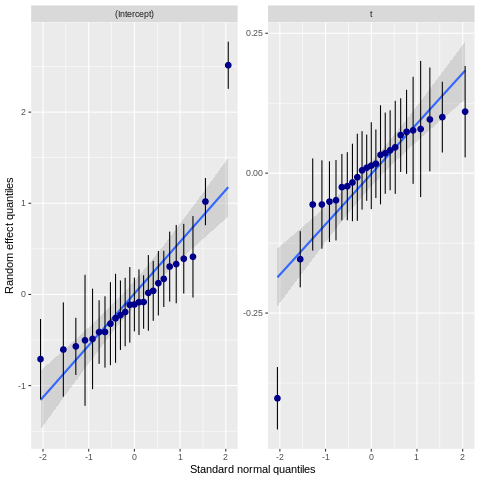

In [130]:
%%R
x = plot_model(m_rs3, grid=T, type="diag")
x[[1]]

Visually, the model has quite good fit with residuals roughly contained within the curve.

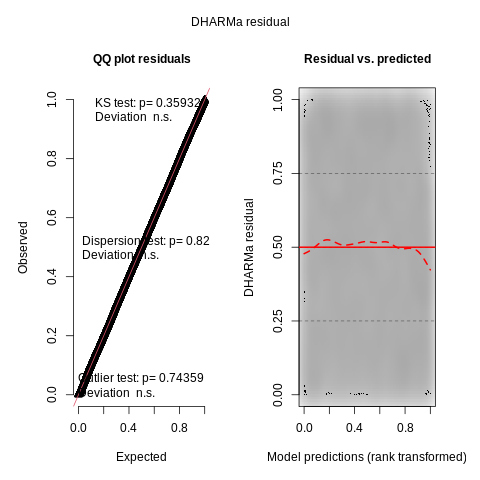

In [131]:
%%R
simulationOutput <- simulateResiduals(fittedModel = m_rs3)
plot(simulationOutput)

Using a simulated output, we can see that the model passes all assumption tests.

## Check if mixed effects model against manual coding

In [132]:
mme_df_mc = turn_df2[turn_df2.coded_by == 1]
mme_df_mc = mme_df_mc[mme_cols]
# rename columns for simplicity
mme_df_mc = mme_df_mc.rename(columns = {"turn":"t","id_threads":"thread"})
# Log center the wordcount to scale the variable
scaler = StandardScaler()
mme_df_mc["log_wc"] = np.log(mme_df_mc.wc)
mme_df_mc["log_wc"] = mme_df_mc.log_wc.mean() - mme_df_mc.log_wc

In [133]:
mme_df_mc.iteritems = mme_df_mc.items

In [134]:
%%R -i mme_df_mc
data <- mme_df_mc

In [135]:
%%R
# use all the best models
f_mc1 = "CR ~ 1 + (1 |sub)"
f_mc2 = "CR ~ 1 + t + log_wc + t:log_wc  + (1 |sub)"
f_mc3 = "CR ~ 1 + t + log_wc + t:log_wc  + (1 + t|sub)"
m_mc1 = glmer(f_mc1, data = data, family="binomial") # No convergence
m_mc2 = glmer(f_mc2, data = data, family="binomial") # Converged
m_mc3 = glmer(f_mc3, data = data, family="binomial") # Converged

In [136]:
%%R
anova(m_mc1, m_mc2)

Data: data
Models:
m_mc1: CR ~ 1 + (1 | sub)
m_mc2: CR ~ 1 + t + log_wc + t:log_wc + (1 | sub)
      npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
m_mc1    2 1289.8 1300.8 -642.91   1285.8                         
m_mc2    5 1274.0 1301.4 -631.98   1264.0 21.865  3   6.96e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [137]:
%%R
anova(m_mc2, m_mc3)

Data: data
Models:
m_mc2: CR ~ 1 + t + log_wc + t:log_wc + (1 | sub)
m_mc3: CR ~ 1 + t + log_wc + t:log_wc + (1 + t | sub)
      npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)
m_mc2    5 1274.0 1301.4 -631.98   1264.0                     
m_mc3    7 1275.4 1313.7 -630.68   1261.4 2.5931  2     0.2735


Best model remains the same - although this time the matrix is singular (likely due to sample size). Qualitatively, results remain very similar to each other, with the same directions of the effects.

In [138]:
%%R
summary(m_mc3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: CR ~ 1 + t + log_wc + t:log_wc + (1 + t | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  1275.4   1313.7   -630.7   1261.4     1768 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0922 -0.3842 -0.3348 -0.2851  3.8266 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 sub    (Intercept) 0.304612 0.55192       
        t           0.005963 0.07722  -1.00
Number of obs: 1775, groups:  sub, 25

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.61908    0.19213 -13.632  < 2e-16 ***
t            0.18349    0.04347   4.221 2.43e-05 ***
log_wc       0.28061    0.13339   2.104   0.0354 *  
t:log_wc    -0.06546    0.03288  -1.991   0.0465 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) t      log_wc
t        -0.853 


Let's check the subreddit intercept probabilities to see if they are also comparable:

In [139]:
%%R -o sub_random_effects,intercept

fixed_effects = fixef(m_mc3)
intercept <- fixed_effects["(Intercept)"]
random_effects <- ranef(m_mc3)
sub_random_effects = random_effects$sub

In [140]:
sub_random_effects = sub_random_effects.reset_index().rename(columns={"index":"subreddit"})
sub_weights = mme_df['sub'].value_counts().reset_index().rename(columns={"sub":"subreddit"})
sub_df5 = mme_df.groupby('sub')['CR'].agg("mean").reset_index()
sub_proportions = sub_df5[["sub","CR"]].rename(columns={"sub":"subreddit","CR":"Raw Probability"})
sub_all = pd.merge(sub_random_effects, sub_weights, on='subreddit', how='inner')
sub_all = pd.merge(sub_all, sub_proportions, on='subreddit', how='inner')
# Replicating Dingemanse and colleagues probabilities
intercept = intercept[0]
m_intercept_sub = sub_all["(Intercept)"].mean()
m_Wintercept_sub = np.average(sub_all["(Intercept)"], weights=sub_all["count"])
sub_all["Probability"] = sub_all["(Intercept)"] + intercept + m_intercept_sub + m_Wintercept_sub
sub_all["Estimated Probability"] =  1 / (1 + np.exp(-sub_all["Probability"]))
sub_all[["subreddit","Estimated Probability", "Raw Probability"]].round(2).sort_values("Raw Probability", ascending = False)

,subreddit,Estimated Probability,Raw Probability
9,IAmA,0.23,0.29
16,psychology,0.04,0.17
14,pics,0.08,0.16
4,changemyview,0.13,0.16
6,explainlikeimfive,0.10,0.15
24,worldnews,0.06,0.15
8,funny,0.09,0.14
10,jokes,0.07,0.14
18,science,0.10,0.14
5,coronavirus,0.06,0.13


In [141]:
correlation, p_value = pearsonr(sub_all["Estimated Probability"], sub_all["Raw Probability"])

print(f"Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Correlation: 0.78
P-value: 0.0000


We see that the manually coded model estimated probabilities have a lower correlation than those in the full dataset. The likelihood is that this is due to scale, with far fewer observations per subreddit.

# Survival analysis

## Cumulative density for time-to-repair (Kaplan Meier).

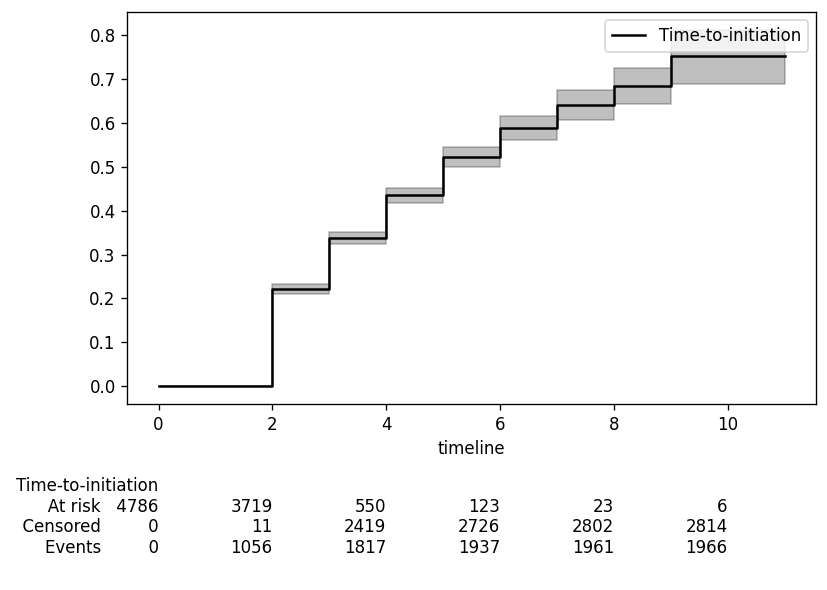

In [142]:
baseline_T = surv_df.TimeToInitiation
baseline_E = surv_df.CR
kmf = KaplanMeierFitter()
ax = None  # Initialize ax
plt.figure(figsize=(7, 5))
kmf.fit(baseline_T, baseline_E, label = "Time-to-initiation")
kmf.plot_cumulative_density(ax=ax, color="black", at_risk_counts = True, loc = slice(0,11))
plt.tight_layout()

The below shows the cumulative density values at each turn with confidence intervals. There are no dialogues only 1 turn in length.

In [143]:
Cum_density = kmf.confidence_interval_cumulative_density_
Cum_density.columns = ["CI Low 95%","CI High 95%"]
Cum_density["Cumulative density"] = kmf.cumulative_density_["Time-to-initiation"]
Cum_density = Cum_density[["Cumulative density", "CI Low 95%","CI High 95%"]]
Cum_density.round(2)

,Cumulative density,CI Low 95%,CI High 95%
0.0,0.00,0.00,0.00
2.0,0.22,0.21,0.23
3.0,0.34,0.32,0.35
4.0,0.43,0.42,0.45
5.0,0.52,0.50,0.54
6.0,0.59,0.56,0.62
7.0,0.64,0.61,0.68
8.0,0.68,0.64,0.72
9.0,0.75,0.69,0.81
10.0,0.75,0.69,0.81


The median survival time is the last time point where 50% of dialogues have not yet experienced repair.

In [144]:
average_time_until_repair = kmf.median_survival_time_ + 1
print(f"Median time until a repair: {average_time_until_repair}")

Median time until a repair: 6.0


## Cumulative hazards

To be able to make predictions about the time-to-repair we may use parametric models and cumulative hazards. Here, we fit different parametric estimators from the Lifelines package to determine the best fit.

,Fitter,AIC,BIC
0,Weibull,10764.31,10777.26
1,LogNormal,10208.26,10221.21
2,LogLogistic,10418.85,10431.80
3,Exponential,12108.86,12115.34


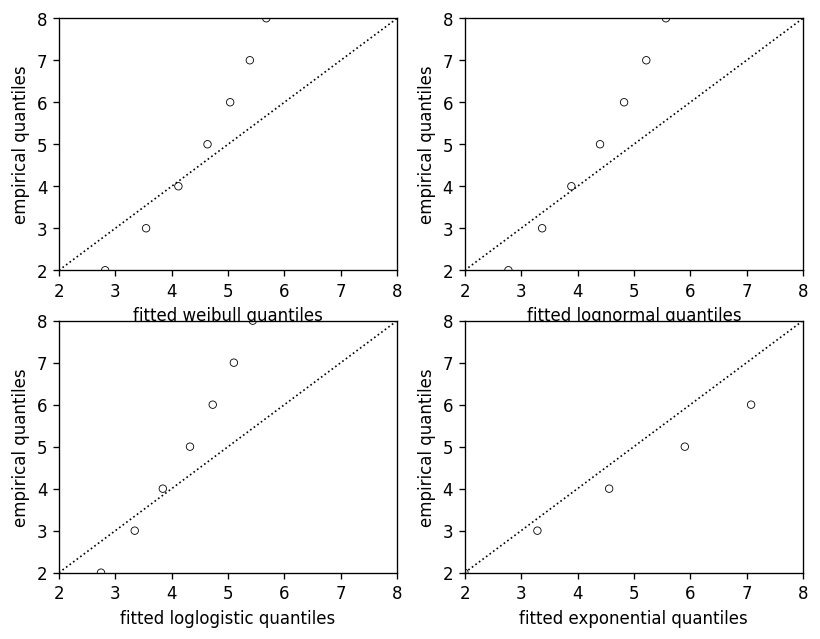

In [145]:
# Parametric models
T = baseline_T
E = baseline_E

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)
AIC_ = []
BIC_ = []
Names_ = ["Weibull","LogNormal","LogLogistic","Exponential"]
for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])
    AIC_.append(model.AIC_)
    BIC_.append(model.BIC_)
AICs = pd.DataFrame({"Fitter":Names_,"AIC":AIC_,"BIC":BIC_}).round(2)
AICs

None of these plots show great fit. However, the exponential curve looks a little better than the non-exponential curve.

We can use lifelines built in function to find the best parametric model.

In [146]:
from lifelines.utils import find_best_parametric_model
best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")
print(best_model)

<lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 2 breakpoint", fitted with 4786 total observations, 2820 right-censored observations>


The recommended model is a piecewise exponential with two breakpoints (i.e., two places where the slope can change in the graph).

However, when using two breakpoints, the piecewise exponential does not fit well (see below)

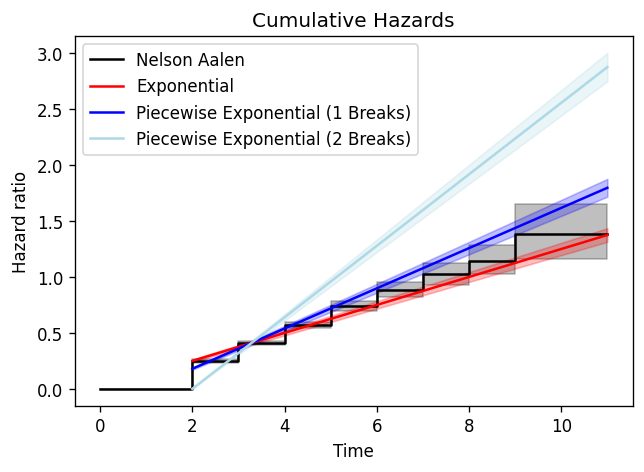

In [147]:
naf = NelsonAalenFitter()
exp = ExponentialFitter()
exp2 = PiecewiseExponentialFitter(breakpoints =[1])
exp3 = PiecewiseExponentialFitter(breakpoints =[1,2])

ax = None  # Initialize axe
plt.figure(figsize=(6, 4))

naf.fit(baseline_T, baseline_E, label = "Nelson Aalen")
naf.plot(ax=ax, loc=slice(0, 20),color="black")


exp.fit(baseline_T, baseline_E, label = "Exponential")
exp.plot(ax=ax, loc=slice(0, 20),color="red")
exp2.fit(baseline_T, baseline_E, label = "Piecewise Exponential (1 Breaks)")
exp2.plot(ax=ax, loc=slice(0, 20),color="blue")

exp3.fit(baseline_T, baseline_E, label = "Piecewise Exponential (2 Breaks)")
exp3.plot(ax=ax, loc=slice(0, 20),color="lightblue")

# Add legend
plt.legend()
plt.title('Cumulative Hazards')
plt.xlabel('Time')
plt.ylabel("Hazard ratio")

# Show the plot
plt.show()

We can see that there is not much visual difference between the two parametric curves. One of the issues is that there are never any requests at the first turn. As such, **we assume that the analysis starts at the second turn (first opportunity for initiation)**.

## Repeat but starting at t=1 rather than t=0

In [148]:
surv_df10 = surv_df[surv_df["dia_len"]!= 1]
surv_df10["TimeToInitiation"] = surv_df10["TimeToInitiation"] - 1

Repeat the kaplan meier curve cumulative density.

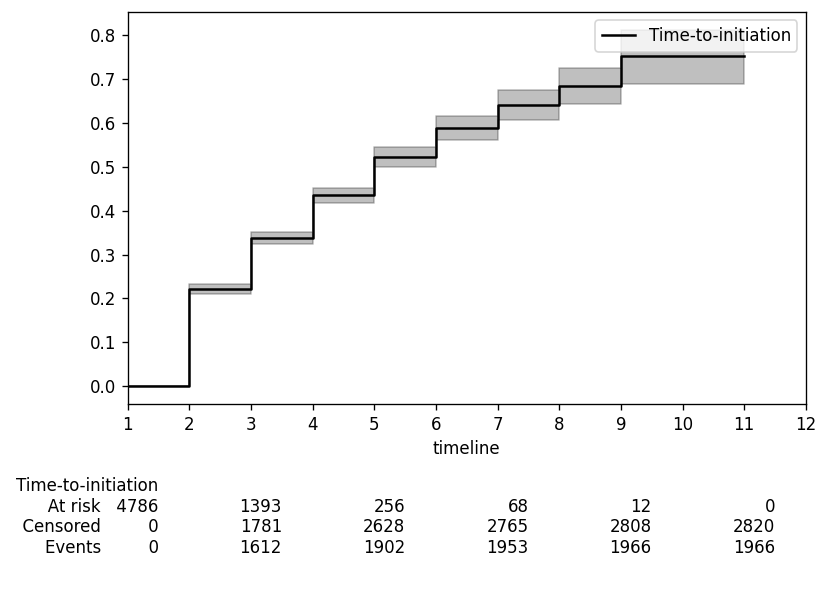

In [149]:
baseline_T = surv_df10.TimeToInitiation
baseline_E = surv_df10.CR
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))
ax = plt.gca()
kmf.fit(baseline_T, baseline_E, label = "Time-to-initiation")
kmf.plot_cumulative_density(ax=ax, color="black", at_risk_counts = True, loc = slice(0,11))

# Set x-axis ticks to be in increments of 1
max_tick = int(baseline_T.max()) + 2  # Find the max tick value and add a buffer
ax.set_xticks(np.arange(0, max_tick, 1))  # Set ticks in increments of 1

# Adjust x-axis tick labels by adding one to each tick
ax.set_xticklabels([str(int(tick + 1)) for tick in ax.get_xticks()])

# Set x-axis limit to start from 0
ax.set_xlim(left=0)

plt.tight_layout()
plt.show()

Now that we have cleaned the data a little and run the Kaplan-Meier non-parametric estimator, let's look at the parametric cumulative hazards.

,Fitter,AIC,BIC
0,Weibull,10231.30,10244.25
1,LogNormal,9808.85,9821.80
2,LogLogistic,10010.61,10023.56
3,Exponential,10681.54,10688.02


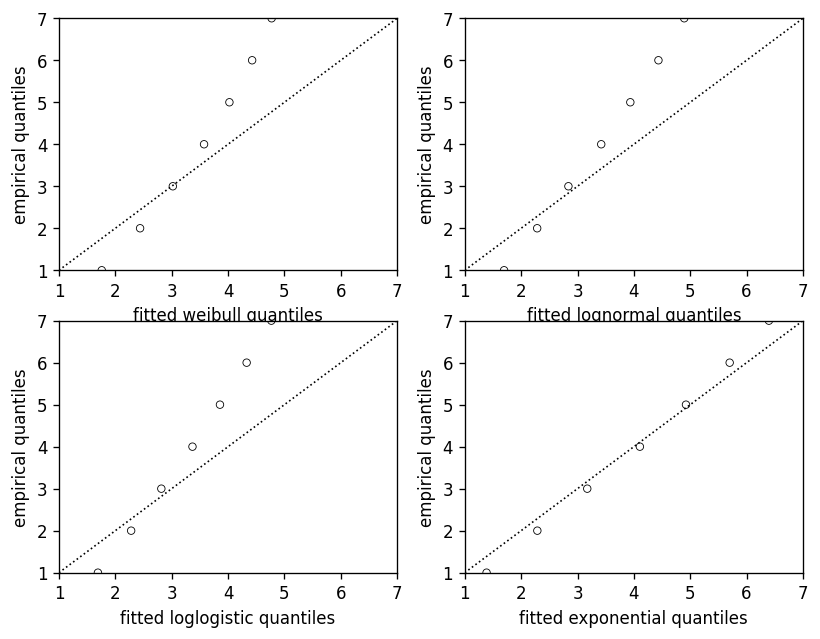

In [150]:
T = surv_df10["TimeToInitiation"]
E = surv_df10["CR"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)
AIC_ = []
BIC_ = []
models = []
Names_ = ["Weibull","LogNormal","LogLogistic","Exponential"]
for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])
    AIC_.append(model.AIC_)
    BIC_.append(model.BIC_)
    models.append(model)
AICs = pd.DataFrame({"Fitter":Names_,"AIC":AIC_,"BIC":BIC_}).round(2)
AICs

According to the BIC and AIC, exponential model performs worst. However, visually, these don't seem to fit the assumptions while the fitted exponential is now consistently distributed against the quantiles.

We can view the results of the new exponential survival model survival model below:

In [151]:
exp = models[3]
exp.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 4786 total observations, 2820 right-censored observations>
   number of observations = 4786
number of events observed = 1966
           log-likelihood = -5339.77
               hypothesis = lambda_ != 0

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_  5.56      0.13            5.32            5.81

         cmp to     z      p  -log2(p)
lambda_    0.00 44.34 <0.005       inf
---
AIC = 10681.54

## Cumulative hazard plots

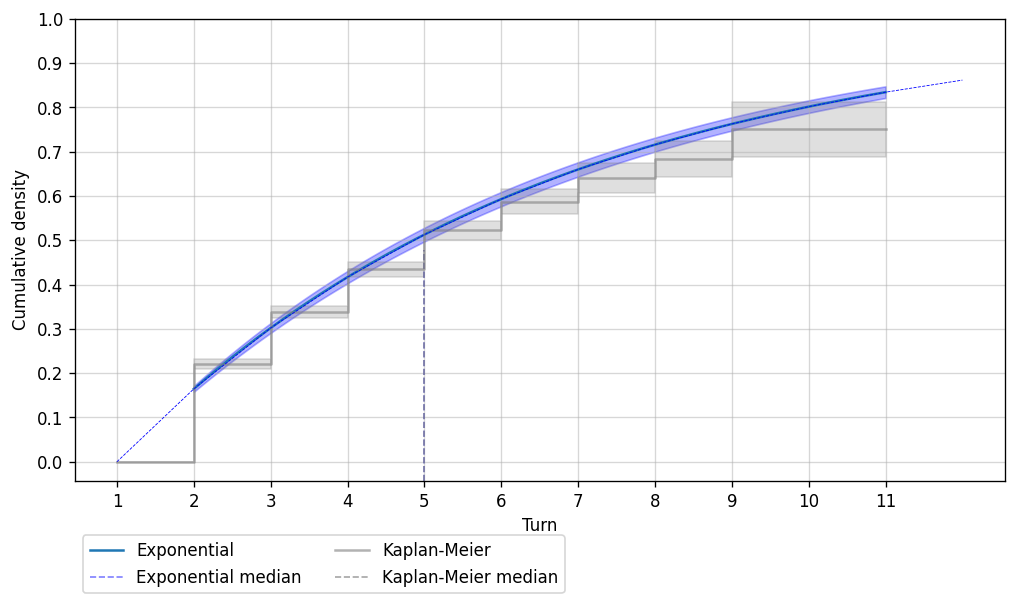

In [152]:
# Assuming 'T' and 'E' are defined before this point
plt.rcParams['figure.figsize'] = [10, 5]
plot_exponential_density(T,E,12)

We can use the exponential fitter to estimate the cumulative density beyond the final recorded time.

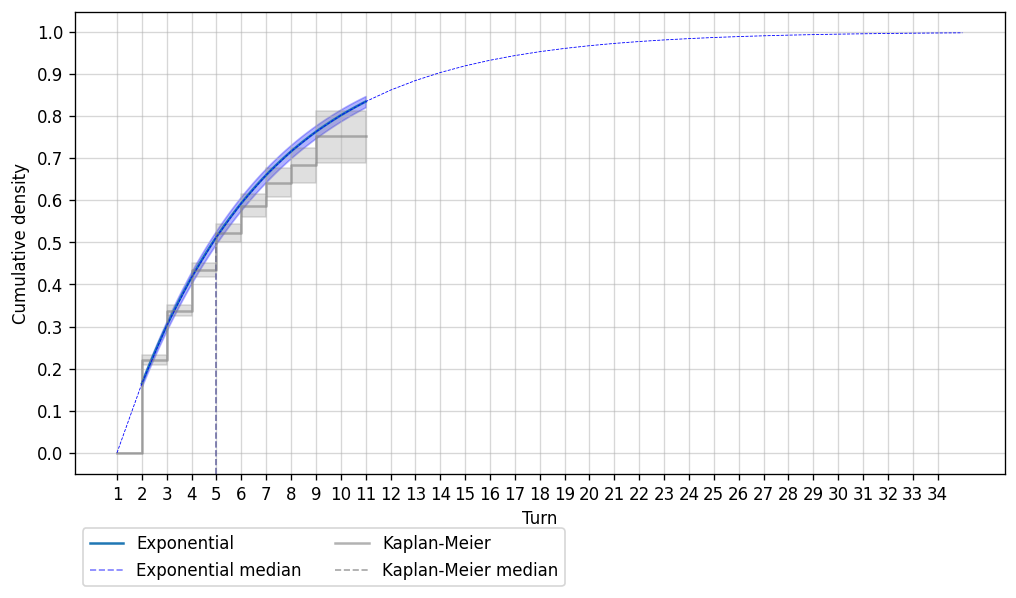

In [153]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_exponential_density(T, E, 35)

We can observe that, as the dialogue progresses, the exponential fitter expects it to approach one fairly quickly (i.e., a dialogue will have experienced a repair).

We can also get a direct estimate of when a dialogue would be getting close.

In [154]:
mxt = 40 # Max time to prediction
prd = get_cumulative_density(exp, max_time=mxt)
turn_at_50 = prd[prd["Cumulative density"] >= 0.5].Time.min()
turn_at_95 = prd[prd["Cumulative density"] >= 0.95].Time.min()
turn_at_99 = prd[prd["Cumulative density"] >= 0.99].Time.min()
print(f"At time {turn_at_50+1}, 50% of dialogues are estimated to experience a repair.")
print(f"At time {turn_at_95+1}, 95% of dialogues are estimated to experience a repair.")
print(f"At time {turn_at_99+1}, 99% of dialogues are estimated to experience a repair.")

At time 5, 50% of dialogues are estimated to experience a repair.
At time 18, 95% of dialogues are estimated to experience a repair.
At time 27, 99% of dialogues are estimated to experience a repair.


## Survival across subreddits

First, we can estimate the median survival time for each of the subreddits. This is a non-

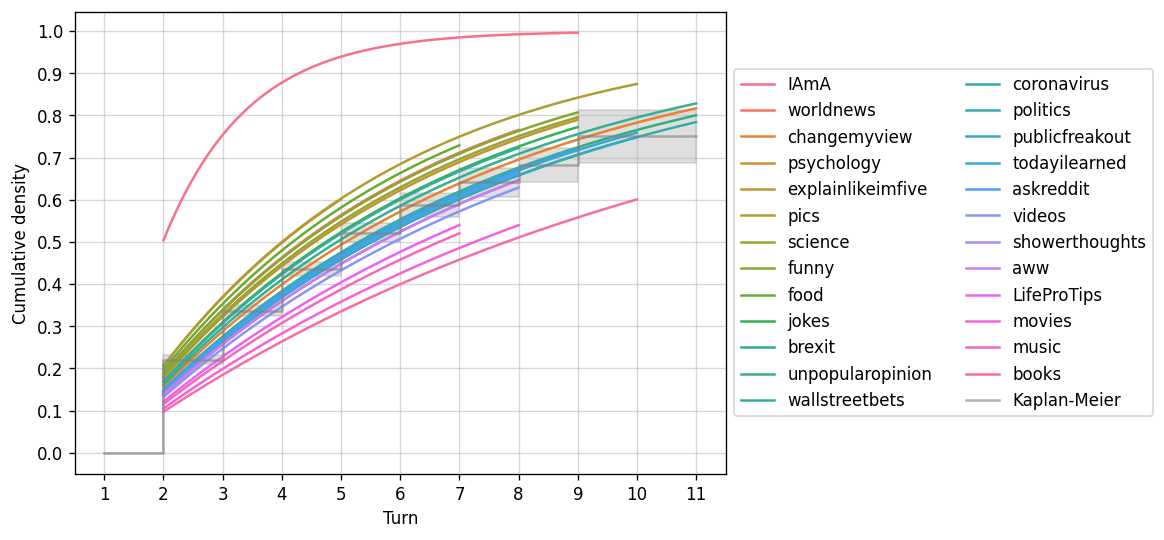

In [155]:
sub_df = surv_df10.groupby("sub").agg({"CR":"mean"}).reset_index()
sub_df = sub_df.sort_values("CR",ascending=False)
sub_order = sub_df["sub"].to_list()
exp = ExponentialFitter()
plt.figure(figsize=(7, 5))
surv_df
# Initialize ax outside the loop
ax = plt.subplot(111)
colors = sns.color_palette('husl', len(surv_df10["sub"].unique()))

for i, sub in enumerate(sub_order):
    T_temp = surv_df10[surv_df10["sub"] == sub].TimeToInitiation
    E_temp = surv_df10[surv_df10["sub"] == sub].CR
    exp.fit(T_temp, E_temp, label=sub)
    exp.cumulative_density_.plot(ax=ax, color = colors[i])
kmf = KaplanMeierFitter()
kmf.fit(T,E, label = "Kaplan-Meier")
kmf.plot_cumulative_density(ax=ax, loc=slice(0, 20),color="grey", alpha=0.6)

old_ticks = list(range(0,11))
new_ticks = list(range(1,12))
plt.xticks(old_ticks, new_ticks)
# Set custom ticks on the y-axis at 0.1 intervals
custom_ticks_y = np.arange(0, 1.1, 0.1)
plt.yticks(custom_ticks_y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.xlabel('Turn')
plt.ylabel('Cumulative density')
plt.grid(True, alpha=0.5)
plt.show()

As expected, we can see that the IAmA is a clear outlier again, supporting the findings from the mixed effects model. However, it should be noted that these exponential models are not validated and, therefore, are only exploratory. We can also see the non-parametric and parametric estimations of survival time:


In [156]:

kmf = KaplanMeierFitter()
exp = ExponentialFitter()
mst = []
mst_e = []
for i, sub in enumerate(sub_order):
    T_temp = surv_df10[surv_df10["sub"] == sub].TimeToInitiation
    E_temp = surv_df10[surv_df10["sub"] == sub].CR
    kmf.fit(T_temp, E_temp, label=sub)
    exp.fit(T_temp, E_temp, label=sub)
    mst.append(kmf.median_survival_time_)
    mst_e.append(exp.median_survival_time_)
pd.DataFrame({"sub":sub_order, "median survival":mst,"median survival estimate":mst_e}).round().sort_values("median survival")

,sub,median survival,median survival estimate
0,IAmA,1.0,1.0
1,worldnews,3.0,3.0
17,askreddit,4.0,4.0
15,publicfreakout,4.0,4.0
13,coronavirus,4.0,5.0
11,unpopularopinion,4.0,4.0
8,food,4.0,3.0
12,wallstreetbets,4.0,4.0
6,science,4.0,3.0
7,funny,4.0,3.0


# Cox regression model

In [157]:
surv_df10["log_wc"] = np.log(surv_df10.wc)
surv_df10["log_wc"] = surv_df10.log_wc.mean() - surv_df10.log_wc

In [158]:
surv_df10["PostType"] = surv_df10["PostType"].apply(lambda x: 1 if x == "Text" else 0)

In [159]:
surv_df11 = surv_df10[["TimeToInitiation","CR","aut","wc","PostType"]]
#create the three models we'd like to compare.
aaf = AalenAdditiveFitter()
weib = WeibullAFTFitter()
cph = CoxPHFitter()
# Cox model best for predicting survival times according to the concordance
mean_cox = np.mean(k_fold_cross_validation(cph, surv_df11, duration_col='TimeToInitiation', event_col='CR', scoring_method="concordance_index"))
mean_AalenAdditive = np.mean(k_fold_cross_validation(weib, surv_df11, duration_col='TimeToInitiation', event_col='CR', scoring_method="concordance_index"))
mean_Weibull = np.mean(k_fold_cross_validation(aaf, surv_df11, duration_col='TimeToInitiation', event_col='CR', scoring_method="concordance_index"))
print(f"Cox PH model Concordance-index mean = {mean_cox:.2f}")
print(f"Aalen Additive model Concordance-index mean = {mean_AalenAdditive:.2f}")
print(f"Weibull model Concordance-index mean = {mean_Weibull:.2f}")

Cox PH model Concordance-index mean = 0.53
Aalen Additive model Concordance-index mean = 0.51
Weibull model Concordance-index mean = 0.51


All of the models have a very low concordance index (0.50 is no better than chance), indicating a regression model may not be appropriate.

Let us run a model anyway as we may be able to distinguish where there are problems with the proportional hazards.

In [160]:
formulas = ["aut + wc + PostType + aut:wc + wc:PostType",
            "aut + wc + PostType + wc:PostType",
            "aut + wc + PostType",
            "aut + wc",
            "aut + PostType",
            "wc + PostType",
            "aut",
            "wc",
            "PostType"]
def run_regression(f):
  try:
    m = CoxPHFitter().fit(surv_df10,duration_col="TimeToInitiation", event_col="CR", strata = "sub",formula = f)
    return m
  except:
    print(f"failed for: {f}")
models = [run_regression(f) for f in formulas]

partial_AIC_(surv_df10, model_names = formulas,models = models)

,Model,Partial AIC
1,aut + wc + PostType + wc:PostType,18970.825
0,aut + wc + PostType + aut:wc + wc:PostType,18971.074
5,wc + PostType,18972.165
7,wc,18972.172
2,aut + wc + PostType,18972.851
3,aut + wc,18973.082
6,aut,18995.070
8,PostType,18995.413
4,aut + PostType,18995.808


There is almost no difference between the more complex models and the models with only word count. However, upon further exploration, only the model with PostType passes the proportional hazards assumption (3rd worst according to the AIC).

In [161]:
f = "PostType"
mi = CoxPHFitter().fit(surv_df10, duration_col="TimeToInitiation", event_col="CR", strata = "sub", formula = f)
mi.check_assumptions(surv_df10)

Proportional hazard assumption looks okay.


[]

Upon inspection, we can see that the model has very low concordance (0.51) indicating it is performing at chance level. We also see the effect of the post type is insignificant, meaning the time until an initiation is not predicted by the type of post. Indeed, the null model (subreddits as strata only) has a higher concordance (0.53) indicating it is the best model.

In [162]:
mi.print_summary()

<lifelines.CoxPHFitter: fitted with 4786 total observations, 2820 right-censored observations>
             duration col = 'TimeToInitiation'
                event col = 'CR'
                   strata = sub
      baseline estimation = breslow
   number of observations = 4786
number of events observed = 1966
   partial log-likelihood = -9496.71
         time fit was run = 2024-07-08 16:14:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
PostType   0.09      1.09      0.08           -0.08            0.25                0.93                1.28

           cmp to    z    p  -log2(p)
covariate                            
PostType     0.00 1.03 0.30      1.73
---
Concordance = 0.51
Partial AIC = 18995.41
log-likelihood ratio test = 1.07 on 1 df
-log2(p) of ll-ratio test = 1.73

<Axes: xlabel='log(HR) (95% CI)'>

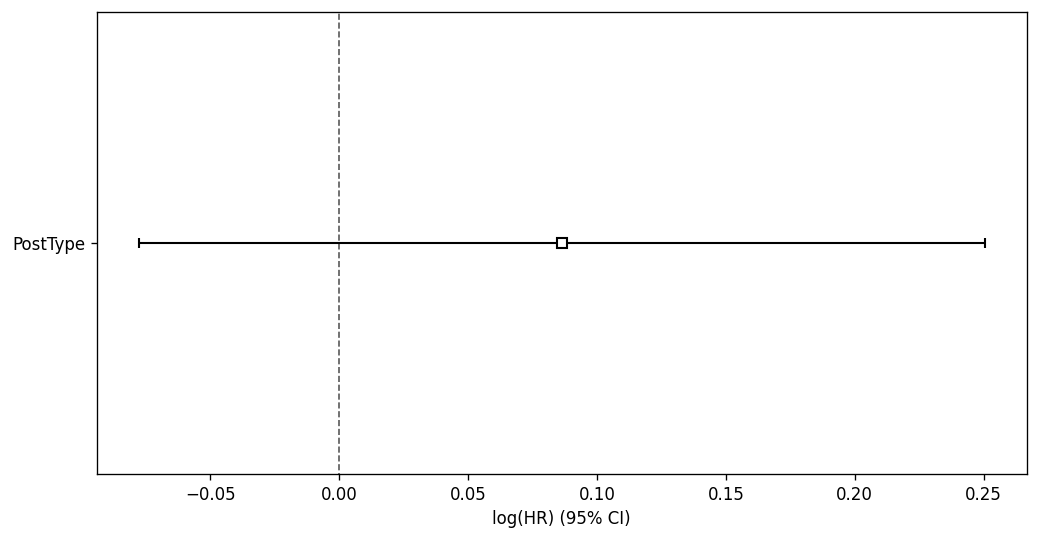

In [163]:
mi.plot()